# Environmental Sound Classification

---
[Mattia Pujatti](mattia.pujatti.1@studenti.unipd.it), ID 1232236, master degree in Physics of Data

---

This notebook has been realized as final project for the course of Human Data Analytics, held by professors [Michele Rossi](rossi@dei.unipd.it) and [Francesca Meneghello](meneghello@dei.unipd.it), during the academic year 2019/2020 at the University of Padua.

#### [Introduction](#Introduction) | [Dataset](#The-Dataset) | [Audio Features](#Audio-Features) | [Example of Analysis](#Example) | [Dataset Construction](#Dataset-Construction)

## Introduction

*The main purpose of this notebook will be to provide an efficient way, using machine learning techniques, to classify environmental sound clips belonging to one of the only public available dataset on the internet. <br>
Several approaches have been tested during the years, but only a few of them were able to reproduce or even overcome the human classification accuracy, that was estimated around 81.30%. <br>
The analysis will be organized in the following way: since the very first approaches were maily focused on the examination of audio features that one could extract from raw audio files, we will provide a way to collect and organize all those "vector of features" and use them to distinguish among different classes. Then, different classification architectures and techniques will be implemented and compared among each other, in order also to show how they react to different data manipulation (overfitting, numerical stability,...). <br>
In the end, it will be shown that all those feature classifiers, without exceptions, underperform when compared to the results provided by the use of Convolutional Neural Networks directly on audio signals and relative spectrograms (so without any kind of feature extraction), and how this new approach opened for a large number of opportunities in term of models with high accuracy in sound classification.*

Most of the audio features that we are interested about for our classifier will be extracted from those clips exploiting the powerful and complete functions provided by the library [librosa](https://librosa.org/doc/latest/index.html), for Python.

In [169]:
# Requirements
import os
from tqdm.notebook import tqdm
import requests
import zipfile
import pydub
import numpy as np
import IPython
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec
import warnings

sns.set_theme()
warnings.filterwarnings('ignore')

## The Dataset

One of the main obstacle in research activities focused on environmental sound classification was the scarcity of large public datasets to exploit to train our networks. Luckily, a few years ago, thank to the work of Karol J. Piczak, form the University of Warsav, a set of 2000 recordings from the **[Freesound.org project](http://freesound.org/)**, representing 50 classes of various common sounds, were collected and correctly labeled, forming one the first accessible dataset for this kind of problems. A large number of papers have been written in the last years, each of them proposing a new and more efficient approach to classify those kind of clips, even surpassing the human classification accuracy. In this notebook we will try to do the same: first analyzing some of the audio features that we can extract from the tracks, that can be used to distinguish among various classes, and then implementing a multivariate analysis technique, like neural networks. 

The **ESC-50 dataset** is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.

The dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories:

| <sub>Animals</sub> | <sub>Natural soundscapes & water sounds </sub> | <sub>Human, non-speech sounds</sub> | <sub>Interior/domestic sounds</sub> | <sub>Exterior/urban noises</sub> |
| :--- | :--- | :--- | :--- | :--- |
| <sub>Dog</sub> | <sub>Rain</sub> | <sub>Crying baby</sub> | <sub>Door knock</sub> | <sub>Helicopter</sub></sub> |
| <sub>Rooster</sub> | <sub>Sea waves</sub> | <sub>Sneezing</sub> | <sub>Mouse click</sub> | <sub>Chainsaw</sub> |
| <sub>Pig</sub> | <sub>Crackling fire</sub> | <sub>Clapping</sub> | <sub>Keyboard typing</sub> | <sub>Siren</sub> |
| <sub>Cow</sub> | <sub>Crickets</sub> | <sub>Breathing</sub> | <sub>Door, wood creaks</sub> | <sub>Car horn</sub> |
| <sub>Frog</sub> | <sub>Chirping birds</sub> | <sub>Coughing</sub> | <sub>Can opening</sub> | <sub>Engine</sub> |
| <sub>Cat</sub> | <sub>Water drops</sub> | <sub>Footsteps</sub> | <sub>Washing machine</sub> | <sub>Train</sub> |
| <sub>Hen</sub> | <sub>Wind</sub> | <sub>Laughing</sub> | <sub>Vacuum cleaner</sub> | <sub>Church bells</sub> |
| <sub>Insects (flying)</sub> | <sub>Pouring water</sub> | <sub>Brushing teeth</sub> | <sub>Clock alarm</sub> | <sub>Airplane</sub> |
| <sub>Sheep</sub> | <sub>Toilet flush</sub> | <sub>Snoring</sub> | <sub>Clock tick</sub> | <sub>Fireworks</sub> |
| <sub>Crow</sub> | <sub>Thunderstorm</sub> | <sub>Drinking, sipping</sub> | <sub>Glass breaking</sub> | <sub>Hand saw</sub> |

Clips in this dataset have been manually extracted from public field recordings gathered by the **[Freesound.org project](http://freesound.org/)**. The dataset has been prearranged into 5 folds for comparable cross-validation, making sure that fragments from the same original source file are contained in a single fold.

---

Directory content:

- `audio/*.wav`

  2000 audio recordings in WAV format (5 seconds, 44.1 kHz, mono) with the following naming convention:
  
  `{FOLD}-{CLIP_ID}-{TAKE}-{TARGET}.wav`
  
  - `{FOLD}` - index of the cross-validation fold,
  - `{CLIP_ID}` - ID of the original Freesound clip,
  - `{TAKE}` - letter disambiguating between different fragments from the same Freesound clip,
  - `{TARGET}` - class in numeric format [0, 49].

- `meta/esc50.csv`

  CSV file with the following structure containing the labels of the clips:
  
  | <sub>filename</sub> | <sub>fold</sub> | <sub>target</sub> | <sub>category</sub> | <sub>esc10</sub> | <sub>src_file</sub> | <sub>take</sub> |
  | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
  
  The `esc10` column indicates if a given file belongs to the *ESC-10* subset (another version of this dataset with 10 selected classes). 

---

A more thorough description of the dataset is available in the original [paper](http://karol.piczak.com/papers/Piczak2015-ESC-Dataset.pdf) , while the main folder of the project can be found on [github](https://github.com/karolpiczak/ESC-50).

Let's check if the dataset has already been downloaded and is present in the working directory: if not, the zip file available [here](https://github.com/karolpiczak/ESC-50/rchive/master.zip) will be downloaded and extracted in a folder named "ESC-50-master". If the zip file is already present, then it is extracted as well if the folder does not exists yet.

In [2]:
direct_download_link = "https://github.com/karoldvl/ESC-50/archive/master.zip"

In [3]:
def get_data(url):
    """ Download the zip datafile from the direct download link, generating the folder containing the audio files,
    the metadata and some old analysis. The function checks first if the file already exists, and if it is 
    of the correct dimension, if not, it will be deleted and re-downloaded. If the zip file is already present 
    but not extracted, il will be. (If running in colab, you cannot use requests, and so you need to upload 
    manually the zip file). """
    
    zipfilename = 'ESC-50-master.zip'
    dirname = 'ESC-50-master'

    # Check the dimension of the file
    
    # Many times apparently the connection is not complete, so we repeat until success
    total_size = None
    attempt = 1
    while total_size==None:
        try:         # connect
            print("Trying to connect... attempt ", attempt)
            response = requests.get(url, stream=True)
            total_size = int(response.headers.get('Content-Length')) # in bytes
        except:
            attempt += 1
            response.close()
    
    if (abs(os.path.getsize(zipfilename) - total_size) > 1024*1024): # checking the difference to be at most 1MB
        os.remove(zipfilename)
    # Check if the data folder already exists
    if not os.path.exists(dirname):
        # Check if the zip file has already been downloaded
        if not os.path.exists(zipfilename):
            # Download the file from the direct link reported above
            with open(zipfilename, 'wb') as f: 
                with tqdm(total=total_size, unit='B', unit_scale=True, unit_divisor=1024, 
                          desc='Downloading the file...') as pbar:        
                    for data in response.iter_content(32*1024):            
                        f.write(data)
                        pbar.update(len(data))
        # Unzip the file
        with zipfile.ZipFile(zipfilename) as zf:
            for member in tqdm(zf.infolist(), desc='Unzipping the file...'):
                try:
                    zf.extract(member, dirname)
                except zipfile.error as e:
                    pass        
    response.close()

In [4]:
# Download or extract the dataset
get_data(direct_download_link)

# In the folder just downloaded there is a sub-directory "audio" that contains 
# all the audio file that we are going to analyze.
audio_dir = os.getcwd() + '/ESC-50-master' + '/ESC-50-master' + '/audio/'

Trying to connect... attempt  1
Trying to connect... attempt  2
Trying to connect... attempt  3
Trying to connect... attempt  4
Trying to connect... attempt  5
Trying to connect... attempt  6
Trying to connect... attempt  7
Trying to connect... attempt  8
Trying to connect... attempt  9
Trying to connect... attempt  10
Trying to connect... attempt  11
Trying to connect... attempt  12
Trying to connect... attempt  13
Trying to connect... attempt  14
Trying to connect... attempt  15
Trying to connect... attempt  16
Trying to connect... attempt  17
Trying to connect... attempt  18
Trying to connect... attempt  19
Trying to connect... attempt  20
Trying to connect... attempt  21
Trying to connect... attempt  22
Trying to connect... attempt  23
Trying to connect... attempt  24
Trying to connect... attempt  25
Trying to connect... attempt  26
Trying to connect... attempt  27
Trying to connect... attempt  28
Trying to connect... attempt  29
Trying to connect... attempt  30
Trying to connect..

In [5]:
# Since the labels are represented by a numerical class in [0-49], it would be nice to have a way to
# associate the name of the class to the label.
label_map = {}
label_df = pd.read_csv(os.getcwd()+'/ESC-50-master/ESC-50-master/meta/esc50.csv')
for i in range(50):
    label_map[i] = label_df.loc[label_df["target"]==i, "category"].unique()[0]

In [6]:
# And the same approach can be useful to distinguish among different macro-categories
# Each macro-category corresponds to a range of "target" parameters among the labels
def macro_categories_map(label):
    if label in [i for i in range(10)]   : return 'Animals' 
    if label in [i for i in range(10,20)]: return 'Natural soundscapes and water sounds'
    if label in [i for i in range(20,30)]: return 'Human, non-speech sounds'  
    if label in [i for i in range(30,40)]: return 'Interior/domestic sounds'
    if label in [i for i in range(40,50)]: return 'Exterior/urban noises'   
    else:
        print("Invalid label input")
        return None

## Audio Features

Next, we will define a class in order to handle and manipulate audio files: this class will contain all the necessary information to completely identify and analyze a single clip, with a trick that avoid keeping in memory the entire signal. Moreover, it will provide a set of functions, mainly coming from _librosa_, to extract features that could be useful in the final classification. Then, once we have chosen the classification method, we are free to select the subset of features to compute those that appear to be more relevant.

This is the internal structure of the class `Clip`:
- `Class Audio`: the subclass that effectively store the audio track, cutting or padding it with zeros if it is not 5.0s long, and with two functions `__enter__` and `__exit__` that allow for a more efficient memory handling, keeping the raw clip only the time necessary to extract its features;
- `__init__`: the constructor of the main Clip class, it takes in input the path of the clip we are analyzing and the corresponding label;
- `Play`: plays the audio in the clip;
- `DisplayWave`: plot the raw signal stored in the clip;
- `DisplaySpectrogram`: plot the spectrogram of the raw signal stored in the clip;

The available features that can be computed are the following:

- `spectral centroids`: the spectral centroid indicates at which frequency the energy of a spectrum is centered upon or, in other words, it indicates where the "center of mass" for a sound is located;
- `spectral roll off`: it is a measure of the shape of the signal, and represents the frequency at which high frequencies decline to 0;
- `spectral bandwidth`:  is defined as the width of the band of light at one-half the peak maximum (or full width at half maximum [FWHM]) and represents the portion of the spectrum which contains most of the energy of the signal;
- `zero-crossing rate`: is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive;
- `mfcc`: the Mel-Frequency-Cepstral-Coefficient of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope modeling the characteristics of the human voice (according to the Mel scale);
- `chromagram`: is typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, …, B}, is present in the signal (in short, it provides a way to describe a similarities measure between music pieces);
- `delta`: set of coefficients defined as the local derivatives of the mfcc coefficients;
- `delta-delta`: set of coefficients defined as the local derivatives of the delta coefficients, and so the second derivative of the MFCCs;
- `energy`: root-mean-square-energy (RMSE) value for each frame;
- `delta-energy`: delta values of the log-energy for each frame;
- `delta-delta-energy`: delta values of the delta values of the log-energy for each frame.

In [284]:
class Clip():
    """A class to handle those 5.0 seconds clips and extract features from them."""
    
    class Audio:
        """ The actual audio data of the clip.
            Uses a context manager to load/unload the raw audio data. This way clips
            can be processed sequentially with reasonable memory usage, keeping just the 
            features computed but not the entire sound vector.
        """
        
        def __init__(self, path):
            self.path = path
            self.timelength = 5.0
        
        def __enter__(self):
            # In order to prevent having clips longer or smaller than 5 seconds
            self.data, self.rate = librosa.load(self.path, sr=None, duration=self.timelength)
            rawaudiosize = self.timelength*self.rate
            if self.data.shape[0] < rawaudiosize:
                self.raw = np.pad(self.data, pad_width=(0,rawaudiosize-len(self.data)), 
                                   mode='constant', constant_values=0.)
            else:
                self.raw = self.data
                
            return self
        
        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print(exception_type, exception_value, traceback)
            del self.data
            del self.raw
            
            
            
    def __init__(self, path, label_map):
        self.clipname = os.path.basename(path)
        self.path = path
        
        self.fold = int(self.clipname.split('-')[0])
        self.clipID = int(self.clipname.split('-')[1])
        self.take = self.clipname.split('-')[2]
        self.target = int(self.clipname.split('-')[3].split('.')[0])
        self.category = label_map[self.target]
        
        self.audio = Clip.Audio(self.path)
        

    def Compute_Features(self, features_list=[]):
        """ Exploit the functions provided by the librosa library to compute several audio analysis
        features. Available:
        * spectral centroid, spectral rolloff, spectral bandwidth
        * zero-crossing rate
        * mfcc
        * chromagram
        * delta, delta-delta
        * log-energy, delta-log-energy, delta-delta-log-energy
        If the input values is "all" -> compute all the features listed above
        """
        if features_list == "all": 
            features_list = ["spectral centroid", "spectral rolloff", "spectral bandwidth", 
                             "zero-crossing rate", "mfcc", "chromagram", "delta", "delta-delta", 
                             "energy", "delta-energy", "delta-delta-energy"]
        self.features = {}
        
        with self.audio as audio:
            if "spectral centroid" in features_list:
                self._compute_spectral_centroid(audio.raw, audio.rate)
            if "spectral rolloff" in features_list:
                self._compute_spectral_rolloff(audio.raw, audio.rate)
            if "spectral bandwidth" in features_list:
                self._compute_spectral_bandwidth(audio.raw, audio.rate)
            if "zero-crossing rate" in features_list:
                self._compute_zero_crossing_rate(audio.raw)
            if "mfcc" in features_list:
                self._compute_mfcc(audio.raw, audio.rate)
            if "chromagram" in features_list:
                self._compute_chromagram(audio.raw, audio.rate)
            if "delta" in features_list:
                self._compute_delta(self.audio.raw, audio.rate)
            if "delta-delta" in features_list:
                self._compute_delta_delta(audio.raw, audio.rate)
            if "energy" in features_list:
                self._compute_energy(audio.raw)
            if "delta-energy" in features_list:
                self._compute_delta_energy(audio.raw)
            if "delta-delta-energy" in features_list:
                self._compute_delta_delta_energy(audio.raw)
        return 
    
    def _compute_spectral_centroid(self, audio_track, audio_rate):
        """ The spectral centroid indicates at which frequency the energy of a spectrum is centered 
        upon or, in other words, it indicates where the "center of mass" for a sound is located.
        NFRAMES = (clip_length * frame_rate)/ frame_size 
        Since the frame size = 512 samples by default, for those clips NFRAMES = 431."""
        
        if "spectral centroid" not in self.features: 
            self.features["spectral centroid"] = librosa.feature.spectral_centroid(audio_track, sr=audio_rate)[0]            
        return self.features["spectral centroid"]
    
    def _compute_spectral_rolloff(self, audio_track, audio_rate):
        """The spectral roll off is a measure of the shape of the signal. It represents the frequency 
        at which high frequencies decline to 0. 
        Return a vector with size NFRAMES = 431."""
        
        if "spectral rolloff" not in self.features: 
            self.features["spectral rolloff"] = librosa.feature.spectral_rolloff(audio_track, sr=audio_rate)[0]            
        return self.features["spectral rolloff"]
    
    def _compute_spectral_bandwidth(self, audio_track, audio_rate):
        """The bandwidth is defined as the width of the band of light at one-half the peak maximum 
        (or full width at half maximum [FWHM]) and represents the portion of the spectrum which contains 
        most of the energy of the signal.
        Return a vector of size NFRAMES = 431."""
        
        if "spectral bandwidth" not in self.features: 
            self.features["spectral bandwidth"] = librosa.feature.spectral_bandwidth(audio_track, sr=audio_rate, p=2)[0]            
        return self.features["spectral bandwidth"]
    
    def _compute_zero_crossing_rate(self, audio_track):
        """The zero-crossing rate is the rate at which a signal changes from positive to zero to negative 
        or from negative to zero to positive.
        Return a vector of size NFRAMES = 431."""
        
        if "zero-crossing rate" not in self.features: 
            self.features["zero-crossing rate"] = librosa.feature.zero_crossing_rate(audio_track, pad=False)
        return self.features["zero-crossing rate"]
    
    def _compute_mfcc(self, audio_track, audio_rate):
        """The Mel-Frequency-Cepstral-Coefficient of a signal are a small set of features (usually about 10–20 
        but we will keep) only the first 13 of each frame), which concisely describe the overall shape of a 
        spectral envelope modeling the characteristics of the human voice (according to the Mel scale).
        The first coefficient is usually discarded because it is less interesting.
        The function returns a vector of shape (12, NFRAMES) = (12,431)."""
        
        if "mfcc" not in self.features: 
            self.features["mfcc"] = librosa.feature.mfcc(audio_track, sr=audio_rate, n_mfcc=13)[1:]
        return self.features["mfcc"]
    
    def _compute_chromagram(self, audio_track, audio_rate):
        """A chromagram is typically a 12-element feature vector indicating how much energy of each pitch 
        class, {C, C#, D, D#, E, …, B}, is present in the signal. In short, it provides a way to describe 
        similarities between music pieces).
        The function returns a vector of shape (12, NFRAMES) = (12,431)."""
        
        if "chromagram" not in self.features: 
            self.features["chromagram"] = librosa.feature.chroma_stft(audio_track, sr=audio_rate)
        return self.features["chromagram"]
    
    def _compute_delta(self, audio_track, audio_rate):
        """Delta are a set of coefficients defined as the local derivatives of the mfcc (or logenergy) 
        coefficients. The function returns a vector of size (12, NFRAMES) = (12,431)."""
        
        if "delta" not in self.features: 
            self.features["delta"] = librosa.feature.delta(self._compute_mfcc(audio_track, audio_rate), order=1)
        return self.features["delta"]
    
    def _compute_delta_delta(self, audio_track, audio_rate):
        """Delta are a set of coefficients defined as the local derivatives of the delta (or logenergy) 
        coefficients, and so the second derivative of the MFCCs.
        The function returns a vector of size (12, NFRAMES) = (12,431)."""
        
        if "delta-delta" not in self.features: 
            self.features["delta-delta"] = librosa.feature.delta(self._compute_mfcc(audio_track, audio_rate), order=2)
        return self.features["delta-delta"]
    
    def _compute_energy(self, audio_track):
        """If s(n) is the signal in the time domain, with n being the discrete sampling time, the root mean 
        square energy of a generic frame i is:       E(s_i) = SQRT((1/N)*sum_n s(n)**2)  
        where the sum goes over all the samples in the frame.
        The function returns a vector of size NFRAMES = 431, with one value for each frame."""
        
        if "energy" not in self.features: 
            self.features["energy"] = librosa.feature.rms(audio_track)
        return self.features["energy"]
    
    def _compute_delta_energy(self, audio_track):
        """First derivative of the energy vectors.
        The function returns a vector of size NFRAMES = 431, with one value for each frame."""
        
        if "delta-energy" not in self.features: 
            self.features["delta-energy"] = librosa.feature.delta(self._compute_energy(audio_track), order=1)
        return self.features["delta-energy"]
    
    def _compute_delta_delta_energy(self, audio_track):
        """Second derivative of the energy vectors. 
        The function returns a vector of size NFRAMES = 431, with one value for each frame."""
        
        if "delta-delta-energy" not in self.features: 
            self.features["delta-delta-energy"] = librosa.feature.delta(self._compute_energy(audio_track), order=2)
        return self.features["delta-delta-energy"]
        
    def Play(self):
        """ Exploit the functionality of IPython to run the audio of the clip """
        with self.audio as audio:
            play = IPython.display.Audio(audio.data, rate=audio.rate)
        return play
            
    def DisplayWave(self, ax=None):
        """ Plot the raw signal stored in the clip """
        with self.audio as audio:
            if ax is None: fig, ax = plt.subplots(1,1, figsize=(8,3))
            librosa.display.waveplot(audio.raw, sr=audio.rate, ax=ax, alpha=0.4)
            ax.set_title(r"$\bf{Audio Signal:}$  " + self.category + ' - ' + self.clipname)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude")
        return ax
    
    def DisplaySpectrogram(self, ax=None, cbar=True):
        """ Plot the spectrogram of raw signal stored in the clip """
        with self.audio as audio:
            # We keep default parameters(n_fft=2048, hop_length=512, win_length=2048)
            X = librosa.stft(audio.raw)
            Xdb = librosa.amplitude_to_db(abs(X))
            if ax is None: _, ax = plt.subplots(1,1, figsize=(9,3))
            ss = librosa.display.specshow(Xdb, sr=audio.rate, ax=ax, x_axis='time', y_axis='log', cmap='RdBu_r')
            if cbar: plt.colorbar(ss)
            ax.set_title(r"$\bf{Spectogram:}$  " + self.category + ' - ' + self.clipname)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude (dB)")
        return ax
    
    def DisplayMelSpectrogram(self, ax=None, cbar=True):
        """ Plot the spectrogram in the Mel Scale of raw signal stored in the clip """
        with self.audio as audio:
            # We keep default parameters(n_fft=2048, hop_length=512, win_length=2048)
            X = librosa.feature.melspectrogram(audio.raw, sr=audio.rate)
            Xdb = librosa.amplitude_to_db(abs(X))
            if ax is None: _, ax = plt.subplots(1,1, figsize=(9,3))
            ss = librosa.display.specshow(Xdb, sr=audio.rate, ax=ax, x_axis='time', y_axis='log', cmap='RdBu_r')
            if cbar: plt.colorbar(ss)
            ax.set_title(r"$\bf{Mel Spectogram:}$  " + self.category + ' - ' + self.clipname)
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude (dB)")
        return ax

### Example

In order to have a deeper understanding of the effective meaning of the features that we are computing, we proceed considering a random sample from the clips in the folder.

In [365]:
rnd_clip = Clip(audio_dir + np.random.choice(os.listdir(audio_dir)), label_map)
rnd_clip.Play()

In the following plots we will display the time dependent raw signal of the audio stored in the clip, together with its spectrum of frequencies and the MelSpectrogram, that basically is the same power spectrum, but represented in the Mel scale, which better approximates the human auditory system. 

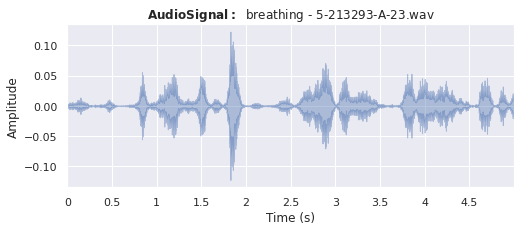

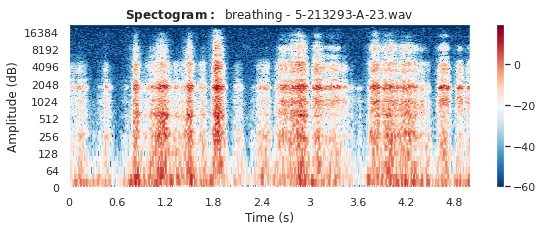

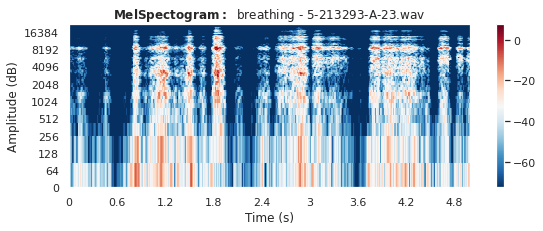

In [366]:
rnd_clip.DisplayWave()
rnd_clip.DisplaySpectrogram()
rnd_clip.DisplayMelSpectrogram();

The formal definition of the features we are going to extract has already been provided above, so we will now go for a visive overview of them: remember that all the quantities listed are frame features, in the sense that we will compute one (or more) value *per frame* for each of them, and since each clip is composed by 431 frames, we will have to deal with entire distributions rather than single values.

In [367]:
rnd_clip.Compute_Features('all')

The first 3 features are directly computed over the spectrum of the wave, and their purpose is to provide an high-level "summarized" description of it. We are talking about the centroids, the rolloffs and the bandwidth parameters.

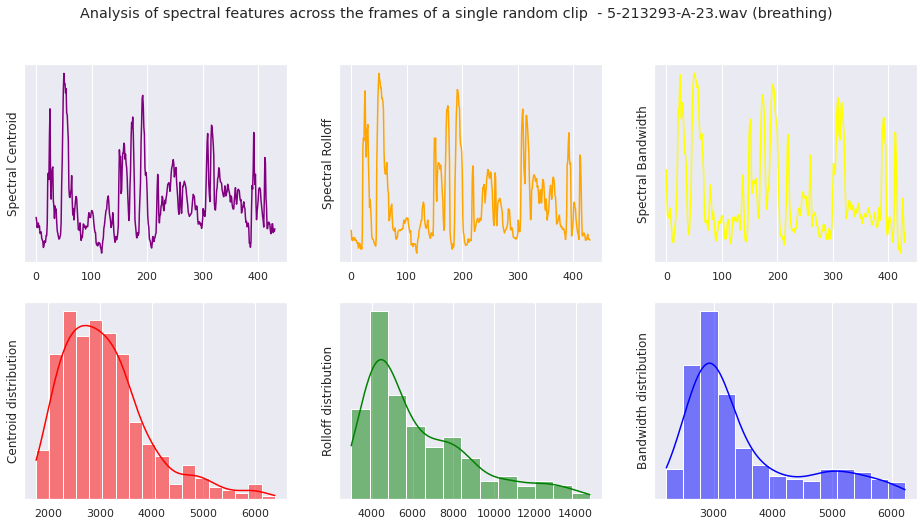

In [368]:
fig, ax = plt.subplots(2,3,figsize=(16,8))
fig.suptitle('Analysis of spectral features across the frames of a single random clip  - ' + 
             rnd_clip.clipname + ' (' + rnd_clip.category + ')' )

sns.lineplot(x=np.arange(431), y=rnd_clip.features['spectral centroid'], color='purple', ax=ax[0,0])
ax[0,0].set_ylabel('Spectral Centroid')
ax[0,0].set_yticks([])

sns.lineplot(x=np.arange(431), y=rnd_clip.features['spectral rolloff'], color='orange', ax=ax[0,1])
ax[0,1].set_ylabel('Spectral Rolloff')
ax[0,1].set_yticks([])

sns.lineplot(x=np.arange(431), y=rnd_clip.features['spectral bandwidth'], color='yellow', ax=ax[0,2])
ax[0,2].set_ylabel('Spectral Bandwidth')
ax[0,2].set_yticks([])

sns.histplot(rnd_clip.features['spectral centroid'], kde=True, color='red', ax=ax[1,0])
ax[1,0].set_ylabel('Centroid distribution')
ax[1,0].set_yticks([])

sns.histplot(rnd_clip.features['spectral rolloff'], kde=True, color='green', ax=ax[1,1])
ax[1,1].set_ylabel('Rolloff distribution')
ax[1,1].set_yticks([])

sns.histplot(rnd_clip.features['spectral bandwidth'], kde=True, color='blue', ax=ax[1,2])
ax[1,2].set_ylabel('Bandwidth distribution')
ax[1,2].set_yticks([]);

The distribution obtained are in general not very regular but anyway "simple", in the sense that they are usually peaked on a certain value, or uniform in a certain interval, depending on the structure of the particular wave analyzed.

But let's give a look to the more interesting part of the analysis, i.e. the features that apparently will be more helpful for a good discrimination (alse the most used for this kind of purposes): the zero-crossing rate and the Mel-Frequency-Cepstral coefficients. First let's recall what do they represent: 
* the _zero crossing rate_ is the rate at which the signal changes from positive to negative and viceversa, and it's a key characteristic of percussive sounds;
* the _MFCC_ are a small set of features which concisely describe the overall shape of a spectral envelope modeling, at the same time, the characteristics of the human voice.

*As explained also in the documentation of the code, only 12 MFCC will be kept, as they are the most interesting, with the very first one being discarded, mainly because its absolute value comes from the normalization of the discrete cosine transform that is performed over the power spectrum.*

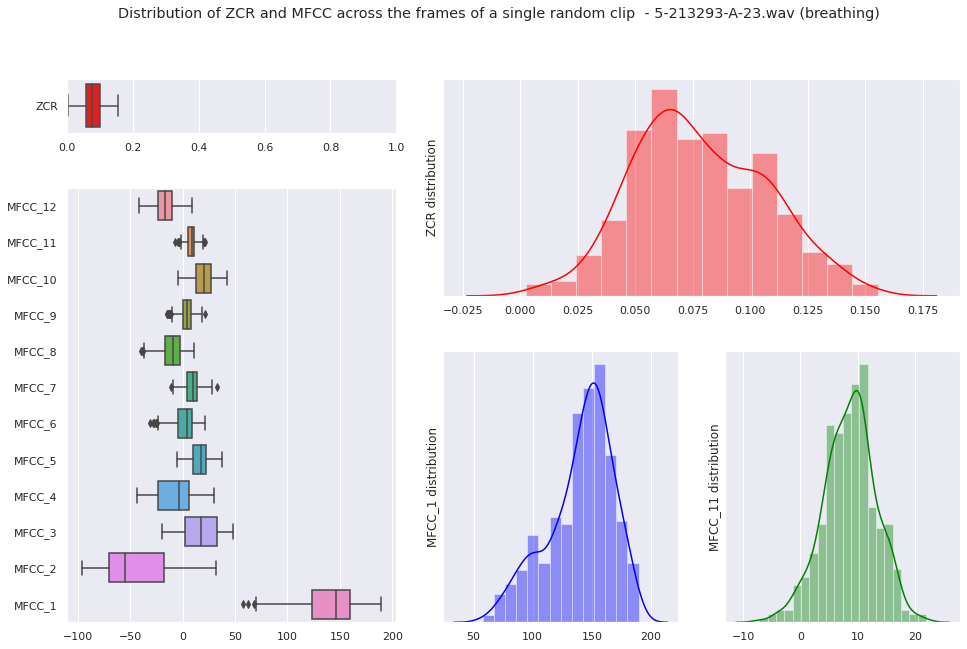

In [369]:
fig = plt.figure(figsize=(16,10))
ax = [0]*5
fig.suptitle('Distribution of ZCR and MFCC across the frames of a single random clip  - ' + 
             rnd_clip.clipname + ' (' + rnd_clip.category + ')' )

grid = GridSpec(10, 10, wspace=1, hspace=0.01)
ax[0] = fig.add_subplot(grid[0  , :4])
ax[1] = fig.add_subplot(grid[2: , :4])
ax[2] = fig.add_subplot(grid[ :4,4: ])
ax[3] = fig.add_subplot(grid[5: ,4:7])
ax[4] = fig.add_subplot(grid[5: ,7:])

MFCC = pd.DataFrame(rnd_clip.features['mfcc'].T, columns=list('MFCC_{}'.format(i+1) for i in range(12)))
ZCR = pd.DataFrame(rnd_clip.features['zero-crossing rate'][0], columns=['ZCR'])

sns.boxplot(data=ZCR, orient='h', color='red', ax=ax[0])
ax[0].set_xlim(0,1)

sns.boxplot(data=MFCC, orient='h', order=list(reversed(MFCC.columns)), ax=ax[1])

sns.distplot(rnd_clip.features['zero-crossing rate'][0], color='red', ax=ax[2])
ax[2].set_ylabel('ZCR distribution')
ax[2].set_yticks([])

sns.distplot(rnd_clip.features['mfcc'][0], color='blue', ax=ax[3])
ax[3].set_ylabel('MFCC_1 distribution')
ax[3].set_yticks([])

rnd_mfcc = np.random.randint(2,12)
sns.distplot(rnd_clip.features['mfcc'][rnd_mfcc], color='green', ax=ax[4])
ax[4].set_ylabel('MFCC_' + str(rnd_mfcc+1) + ' distribution')
ax[4].set_yticks([]);

Looking at the MFCC boxplot, we can clearly see that the first (and in some cases also the second) coefficients are much more dispersed than the others, and this is also confirmed looking at the MFCC_0 distribution shown in the right plot. This means that most of the information provided by those coefficients is stored in the first ones, as expected, since basically they come from a discrete cosine transform. Conventionally only 12 of them are kept for sound classification tasks,, and so we do for our analysis.

However, it is important to specify that these features are mainly used in speech recognition tasks, and so one can expect them to underperform when dealing with environmental sound classification, at least compared to the objective they are designed to. And this is the main reason for which our final "vector of features" is composed also by many other values, in order to provide an high-level description that is as complete as possible, at the expense of computational resources required.

*Second important remark: apparently mfcc values are not very robust when dealing with noisy waves, and this could be a problem when studying environmental sounds, or when performing augmentation in order to have more data to analyze. Actually there is not an "official" procedure to deal with it, just the heuristic suggestions of being careful with the results and normalizing the features between using them.*

The last couple of features that is worth to give a look at (the remaining ones are just the first and second derivatives of the others) are the chromagram and the energy spectrum. The chromagram is a 12 element feature vector, just like the mfcc, indicating how much energy of each pitch class is present in the signal. Environmental audio classification is not the main task for which chromagrams are designed to, since they are more useful when distinguishing among music styles, but in some way they may help also for our task.

In [370]:
CHROMA

,C,,D,,E,F,,G,,A,,B
0,1.000000,0.617272,0.403033,0.143014,0.152558,0.110234,0.071500,0.101348,0.107789,0.171777,0.301057,0.788947
1,1.000000,0.521904,0.440809,0.216202,0.179931,0.170454,0.119313,0.155948,0.166504,0.194676,0.282250,0.814026
2,1.000000,0.597363,0.659946,0.596797,0.365965,0.379806,0.363789,0.298928,0.298291,0.313976,0.369438,0.864263
3,0.480429,0.672738,0.734767,1.000000,0.676022,0.704874,0.600331,0.266718,0.307084,0.433689,0.550789,0.591683
4,0.588985,0.586642,0.996252,1.000000,0.580256,0.552538,0.549753,0.237592,0.291196,0.407264,0.530748,0.600058
...,...,...,...,...,...,...,...,...,...,...,...,...
426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


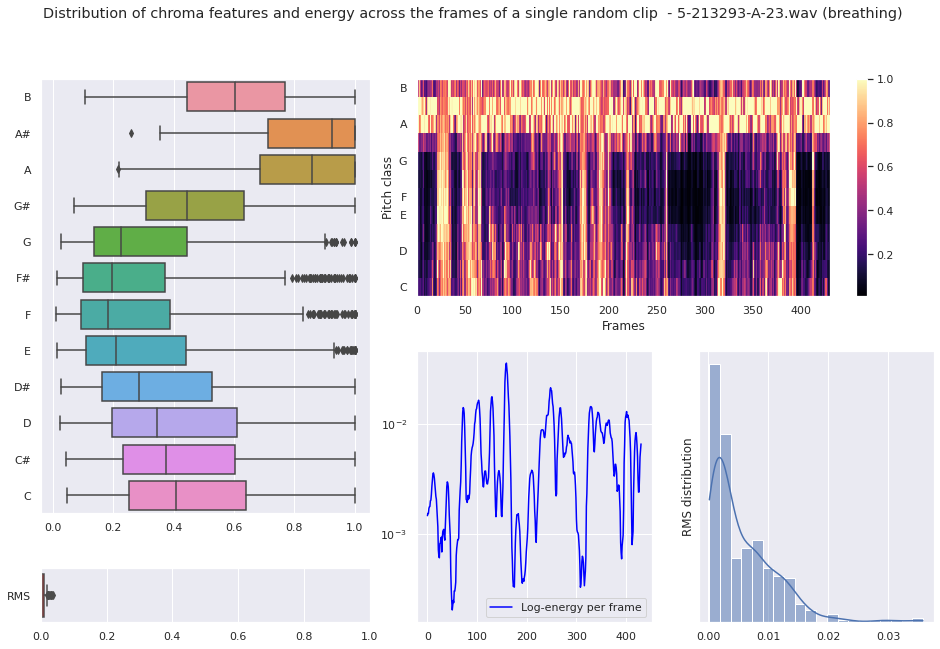

In [382]:
fig = plt.figure(figsize=(16,10))
ax = [0]*5
fig.suptitle('Distribution of chroma features and energy across the frames of a single random clip  - ' + 
             rnd_clip.clipname + ' (' + rnd_clip.category + ')' )

grid = GridSpec(10, 10, wspace=1, hspace=0.01)
ax[0] = fig.add_subplot(grid[0:8, :4])
ax[1] = fig.add_subplot(grid[9  , :4])
ax[2] = fig.add_subplot(grid[ :4,4: ])
ax[3] = fig.add_subplot(grid[5: ,4:7])
ax[4] = fig.add_subplot(grid[5: ,7:])

RMS = pd.DataFrame(rnd_clip.features['energy'][0], columns=['RMS'])
CHROMA = pd.DataFrame(rnd_clip.features['chromagram'].T, 
                      columns=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#' , 'B'])

sns.boxplot(data=CHROMA, orient='h', order=list(reversed(CHROMA.columns)), ax=ax[0])

sns.boxplot(data=RMS, orient='h', color='red', ax=ax[1])
ax[1].set_xlim(0,1);

img = librosa.display.specshow(rnd_clip.features['chromagram'], y_axis='chroma', x_axis='frames', ax=ax[2])
fig.colorbar(img, ax=ax[2])

sns.lineplot(x=np.arange(431), y=rnd_clip.features['energy'][0], ax=ax[3], color='blue', 
             label='Log-energy per frame')
ax[3].set_yscale('log')

sns.histplot(rnd_clip.features['energy'][0], kde=True, stat='density', ax=ax[4])
ax[4].set_ylabel('RMS distribution')
ax[4].set_yticks([]);

## Dataset Construction

Let's now load the entire dataset constructing a labelled dataframe of _Clip_ objects.

In [ ]:
def Collect_Clips(data_dir, label_map, macro_map):
    df = pd.DataFrame(None, columns=["macro-category", "label", "clip"])
    for i, file in enumerate(tqdm(sorted(os.listdir(data_dir)))):
        num_label = int(file.split('-')[3].split('.')[0])
        cat_label = label_map[num_label]
        macro_label = macro_map(num_label)
        track = Clip(data_dir + file, label_map)
        df.loc[i] = macro_label, cat_label, track
    return df
        
data = Collect_Clips(audio_dir, label_map, macro_categories_map)

In [ ]:
data

### Plot Generation

As was anticipated in the introduction, in this analysis we will implement also several Convolutional Neural Networks, with the purpose of provinding a set of tools that guaranteed optimal performances in our classification task even without computing all the features that we have talked about before. But CNN works with images, and for this reason we define a of function able to generate 3 kind of images from our clip dataset: a folder with the time waves, another one with the spectrogram and the last one with all the MelSpectrogram. Later on, the performances of the various networks over these 3 new datasets will be computed and compared. 

In [ ]:
folders = ['time_signals/', 'spectrograms/', 'melspectrograms/']
def save_plots(data):
    for clip in tqdm(data['clip']):
        fig, ax = plt.subplots(1,1,figsize=(6,3))
        clip.DisplayWave(ax)
        ax.set_title('')
        ax.set_axis_off()
        fig.savefig(os.getcwd() + '/audio_plots/' + folders[0] + clip.clipname.split('.')[0], 
                    bbox_inches='tight', pad_inches=0)
        fig.clear()
        
        ax = fig.add_axes([1,1,1,1])
        clip.DisplaySpectrogram(ax, cbar=False)
        ax.set_title('')
        ax.set_axis_off()
        fig.savefig(os.getcwd() + '/audio_plots/' + folders[1] + clip.clipname.split('.')[0], 
                    bbox_inches='tight', pad_inches=0)
        fig.clear()
        
        ax = fig.add_axes([1,1,1,1])
        clip.DisplaySpectrogram(ax, cbar=False)
        ax.set_title('')
        ax.set_axis_off()
        fig.savefig(os.getcwd() + '/audio_plots/' + folders[2] + clip.clipname.split('.')[0], 
                    bbox_inches='tight', pad_inches=0)
        fig.clear()
            
#save_plots(data)

In [ ]:
def clip_overview(clip, ax):
    """Reproduce, in a unique figure, the raw sound, the spectrogram and the Melspectrogram."""
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform       = ax.inset_axes([0.0, 0.8, 1.0, 0.2])
    ax_spectrogram    = ax.inset_axes([0.0, 0.4, 1.0, 0.4])
    ax_melspectrogram = ax.inset_axes([0.0, 0.0, 1.0, 0.4])
    
    with clip.audio as audio:
        librosa.display.waveplot(audio.raw, sr=audio.rate, ax=ax_waveform, alpha=0.4)
        X_s = librosa.stft(audio.raw)
        Xdb_s = librosa.amplitude_to_db(abs(X_s))
        librosa.display.specshow(Xdb_s, sr=audio.rate, ax=ax_spectrogram, x_axis='time', y_axis='log', cmap='RdBu_r')
        X_ms = librosa.feature.melspectrogram(audio.raw, sr=audio.rate)
        Xdb_ms = librosa.amplitude_to_db(abs(X_ms))
        librosa.display.specshow(Xdb_ms, sr=audio.rate, ax=ax_melspectrogram, x_axis='time', y_axis='log', cmap='RdBu_r')
        ax_waveform.set_title(clip.category)    
        
    ax_waveform.get_xaxis().set_visible(False)
    ax_waveform.get_yaxis().set_visible(False)
    ax_spectrogram.get_xaxis().set_visible(False)
    ax_spectrogram.get_yaxis().set_visible(False)
    ax_melspectrogram.get_xaxis().set_visible(False)
    ax_melspectrogram.get_yaxis().set_visible(False)
    
    return

In [ ]:
warnings.filterwarnings('ignore')

for macro_cat in data['macro-category'].unique():
    micro_cat = data.loc[data['macro-category']==macro_cat, 'label'].unique()
    samples_per_category = len(micro_cat)
    print('Macro category:', macro_cat)
    fig, axs = plt.subplots(2, (samples_per_category+1)//2, figsize=(samples_per_category*2, 4), sharex=True, sharey=True)
    axs = axs.flatten()
    
    for i, lab in enumerate(micro_cat):
        cat_clip = np.random.choice(data.loc[(data['macro-category']==macro_cat) & (data['label']==lab), 'clip'])
        clip_overview(cat_clip, axs[i])
    
    plt.show()

In [ ]:
rnd_clip.Compute_Features(["zero-crossing rate"])
plt.hist(rnd_clip.features["zero-crossing rate"][0])

In [ ]:
data

In [ ]:
for index, sample in tqdm(data[(data['macro-category']=='Animals')&(data['label']=='dog')].iterrows()):
    sample['clip'].Compute_Features(['spectral bandwidth'])
    plt.plot(sample['clip'].features['spectral bandwidth'])

In [ ]:
# Extract the features to properly build a machine learning dataset
def extract_features(dataset):
    
    features_df = pd.DataFrame(columns=[i for i in range(55)])
    
    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        # Compute all the features useful for the classification
        sample = row['clip']
        sample.Compute_Features('all')
        
        spec_centroid = [np.mean(sample.features['spectral centroid'])]
        spec_rolloff = [np.mean(sample.features['spectral rolloff'])]
        spec_bandwidth = [np.mean(sample.features['spectral bandwidth'])]
        zcr = [np.mean(sample.features['zero-crossing rate'])]
        mfcc = np.mean(sample.features['mfcc'].T, axis=0)
        chroma = np.mean(sample.features['chromagram'].T, axis=0)
        delta = np.mean(sample.features['delta'].T, axis=0)
        deltadelta = np.mean(sample.features['delta-delta'].T, axis=0)
        logE = [np.mean(sample.features['log-energy'])]
        deltalogE = [np.mean(sample.features['delta-log-energy'])]
        deltadeltalogE = [np.mean(sample.features['delta-delta-log-energy'])]
                
        features_df.loc[index] = np.concatenate([spec_centroid, spec_rolloff, spec_bandwidth, zcr, mfcc, chroma, 
                                             delta, deltadelta, logE, deltalogE, deltadeltalogE])
        
    features_df['label'] = dataset['label']
        
    return features_df

In [ ]:
def extract_more_features(dataset):
    
    features_df = pd.DataFrame(columns=[i for i in range(110)])
    
    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        # Compute all the features useful for the classification
        sample = row['clip']
        sample.Compute_Features('all')
        
        spec_centroid_mean = [np.mean(sample.features['spectral centroid'])]
        spec_centroid_std = [np.std(sample.features['spectral centroid'])]
        spec_rolloff_mean = [np.mean(sample.features['spectral rolloff'])]
        spec_rolloff_std = [np.std(sample.features['spectral rolloff'])]
        spec_bandwidth_mean = [np.mean(sample.features['spectral bandwidth'])]
        spec_bandwidth_std = [np.std(sample.features['spectral bandwidth'])]
        zcr_mean = [np.mean(sample.features['zero-crossing rate'])]
        zcr_std = [np.std(sample.features['zero-crossing rate'])]
        mfcc_mean = np.mean(sample.features['mfcc'].T, axis=0)
        mfcc_std = np.std(sample.features['mfcc'].T, axis=0)
        chroma_mean = np.mean(sample.features['chromagram'].T, axis=0)
        chroma_std = np.std(sample.features['chromagram'].T, axis=0)
        delta_mean = np.mean(sample.features['delta'].T, axis=0)
        delta_std = np.std(sample.features['delta'].T, axis=0)
        deltadelta_mean = np.mean(sample.features['delta-delta'].T, axis=0)
        deltadelta_std = np.std(sample.features['delta-delta'].T, axis=0)
        logE_mean = [np.mean(sample.features['log-energy'])]
        logE_std = [np.std(sample.features['log-energy'])]
        deltalogE_mean = [np.mean(sample.features['delta-log-energy'])]
        deltalogE_std = [np.std(sample.features['delta-log-energy'])]
        deltadeltalogE_mean = [np.mean(sample.features['delta-delta-log-energy'])]
        deltadeltalogE_std = [np.std(sample.features['delta-delta-log-energy'])]
                
        features_df.loc[index] = np.concatenate([spec_centroid_mean, spec_centroid_std, 
                                                 spec_rolloff_mean, spec_rolloff_std, 
                                                 spec_bandwidth_mean, spec_bandwidth_std,
                                                 zcr_mean, zcr_std, mfcc_mean, mfcc_std,
                                                 chroma_mean, chroma_std, delta_mean, delta_std, 
                                                 deltadelta_mean, deltadelta_std, 
                                                 logE_mean, logE_std, 
                                                 deltalogE_mean, deltalogE_std, 
                                                 deltadeltalogE_mean, deltadeltalogE_std])
        
    features_df['label'] = dataset['label']
        
    return features_df

In [ ]:
#more_features = extract_more_features(data)
more_features = pd.read_csv("more_features.csv", index_col=0)
#more_features.to_csv('more_features.csv')

In [ ]:
#features = extract_features(data)
features = pd.read_csv("features.csv", index_col=0)
#features.to_csv("features.csv")

In [ ]:
corr_matrix = features.corr()
_, corr_ax = plt.subplots(figsize=(15,15))

# Since the correlation matrix is symmetric respect to the principal diagonal, we can just plot half of it
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, center=0, mask=mask, ax=corr_ax, linewidths=1,cmap='seismic')
corr_ax.set_title("Correlation matrix of the features")
sns.set(font_scale=2)

# Classification

In [ ]:
from tqdm.keras import TqdmCallback
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings('ignore')

In [ ]:
class ClipsClassifier():
    """The purpose of this class is to collect all the necessary steps and functions to construct a classification
    model for our clips. 
    In particular, all the necessary steps to prepare the input dataset for the training process will 
    be implemented:
    * standardization
    * PCA
    * One Hot Encoding
    * train test split
    Then a k-fold cross validation can be made in order to test several combination of hyperparameters
    without constructing directly a validation set.
    In the end, the performances will be shown in term of accuracy/loss also over different macro-categories
    to finally quantify the quality of the model constructed.
    """
    
    def __init__(self, dataset):
        """Initialize some global parameters.
        Dataset is a pandas dataframe with several "features" columns and one "label" column, 
        that contains the data that we want to fit."""
        
        self.data = dataset        
        self.Setup_Classifier()
        
        self.setup_completed = False
        
        self.best_model = None
        self.hyperparameters_tuning_dict = {}
        self.nested_scores = []
        
        self.confusion_matrix = None
        
        
    def Setup_Classifier(self, pca_percentage=0.99, n_folds=5, n_jobs=-1,
                         scaler_method='standard', encoder_method='onehot'):
        """Change the value of some parameters/methods used during data pre-processing and training step."""
        
        self.n_jobs = n_jobs
        self.scaler = scaler_method
        self.encoder = encoder_method
        self.pca_percentage = pca_percentage
        self.n_folds = n_folds
        
        # The sequent analysis will be performed via nested cross validation
        self.inner_cv = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        self.outer_cv = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        

    def _Setup_Data(self):
        """Performs standardization, PCA and label encoding."""
        
        # Standardize data
        if self.scaler == 'standard':
            std_data = StandardScaler().fit_transform(self.data.drop(['label'], axis=1))
        elif self.scaler == 'minmax':
            std_data = MinMaxScaler(feature_range=(-1,1)).fit_transform(self.data.drop(['label'], axis=1))
        else:
            print('Invalid value of the scaler. Available: standard, minmax')
            return
        
        # Let's apply the PCA keeping just a percentage of the information
        if (self.pca_percentage>0) and (self.pca_percentage<1):
            self.pca = PCA().fit(std_data)
            self.cev = np.cumsum(self.pca.explained_variance_ratio_)
            pca_data = PCA(n_components=np.argmax(self.cev>self.pca_percentage)).fit_transform(std_data)
        else:
            pca_data = std_data

        # Encode the labels
        if self.encoder == 'onehot':
            labels = OneHotEncoder(sparse=False).fit_transform(self.data[['label']].to_numpy())
        elif self.encoder == 'label':
            labels = LabelEncoder().fit_transform(self.data['label'])
        else:
            print('Invalid value of the encoder. Available: onehot, label')
            return
        
        self.setup_completed = True
        self.X = pca_data
        self.Y = labels
        
        
    def PCA_Variance_Ratio(self):
        """When PCA option is active, it plot the comulative sum of the variance ratio, in order
        to represent the amount of information stored in the first principal components."""
        
        if not self.setup_completed: self._Setup_Data()
        
        plt.plot(self.cev, color='red', lw=3, label='cev')
        plt.axvline(np.argmax(cev>self.pca_percentage), ls='--', c='black', lw=1, 
                    label='cev = {}'.format(round(self.cev[np.argmax(cev>0.95)], 2)))
        plt.xlabel('Number of components')
        plt.ylabel('Cumulative explained variance')
        plt.title('Study on the number of principal components')
        plt.legend();

        
    def Run_Grid_Search(self, model, parameters):
        """Because of the small amount of data available, the analysis will be performed running a 
        nested cross validation over the clip set. For tuning the hyperparameters an "inner" K-fold
        splitting will be defined to check which combination works better over the dataset."""
       
        # Standardize, encode and eventually apply pca on the dataset
        if not self.setup_completed: self._Setup_Data()
        
        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=self.n_jobs, 
                           verbose=2, cv=self.inner_cv)
        clf.fit(self.X, self.Y)
        self.hyperparameters_tuning_dict = clf.cv_results_
        self.best_model = clf.best_estimator_
        
        print("Optimal set of hyperparameters: ")
        print(clf.best_params_)
        
        
    
    def Run_Cross_Validation(self, model=None):
        """Because of the small amount of data available, the analysis will be performed running a 
        nested cross validation over the clip set. To estimate the performances of a model, an "outer" 
        K-fold splitting will be defined in order to compute the effective generalized accuracy as 
        the average of the validation values obtained among various folds.
        Because of the stochastic nature of the approach, it may be better to repeat several times the 
        run to check if the results are compatible between themselves."""
        
        # Standardize, encode and eventually apply pca on the dataset
        if not self.setup_completed: self._Setup_Data()
            
        # If not specified, run the validation for the best model found by the grid search
        if model is None: model = self.best_model
        
        # Nested CV cross validation
        self.nested_scores = cross_val_score(model, X=self.X, y=self.Y, n_jobs=self.n_jobs, 
                                             verbose=2, cv=self.outer_cv)
        best_accuracy = np.mean(self.nested_scores)
        
        print("Average final accuracy estimated: {}%".format(round(best_accuracy*100, 2)))  
        
        
    def Compute_Confusion_Matrix(self, model=None):
        """Compute the confusion matrix according to the input model or the best one found by a 
        previous grid search."""
        
        # Standardize, encode and eventually apply pca on the dataset
        if not self.setup_completed: self._Setup_Data()
            
        # If not specified, run the validation for the best model found by the grid search
        if model is None: model = self.best_model
        
        if self.confusion_matrix is None:
            y_pred = cross_val_predict(model, self.X, self.Y, cv=self.outer_cv)
            self.confusion_matrix = confusion_matrix(self.Y, y_pred)
            
        return self.confusion_matrix
        

### Random Forest

In [ ]:
rf = RandomForestClassifier()

params_RF = {'n_estimators': [500, 1000],
             'bootstrap': [True, False],
             'max_samples' : [0.5, None],
             'max_features': ['sqrt']}

rndfor_cc = ClipsClassifier(more_features, rf, params_RF)
# RandomForest underperform with One Hot Encoding, so you need to change to LabelEncoder
rndfor_cc.Setup_Classifier(encoder_method='label', n_jobs=4)
rndfor_cc.Run_Training_Process()


### Multi-layer Perceptron

In [ ]:
mlp = MLPClassifier()

params_MLP = {'hidden_layer_sizes':[128, 256, 512],
             'activation':['logistic', 'relu'],
             'solver':['sgd', 'adam'],
              'learning_rate_init':[0.01, 0.001]}

mlp_cc = ClipsClassifier(more_features, mlp, params_MLP)
mlp_cc.Setup_Classifier(n_jobs=4)
mlp_cc.Run_Training_Process()

### K-Neighbors Classifier

In [ ]:
knc = KNeighborsClassifier()

params_KNC = {'n_neighbors':[2,5,8,10],
             'weights':['uniform', 'distance'],
             'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
             'leaf_size':[10, 30, 50, 100]}

knc_cc = ClipsClassifier(more_features, knc, params_KNC)
knc_cc.Run_Training_Process()

### Neural Network

### Support Vector Machine

In [ ]:
svm = SVC()

params_SVM = {'C':[0.1, 0.5, 1],
             'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

svm_cc = ClipsClassifier(more_features, svm, params_SVM)
svm_cc.Setup_Classifier(encoder_method='label')
svm_cc.Run_Training_Process()

#### Comparison of the approaches for feature classification

In [ ]:
#fig, ax = plt.subplots(1,1,figsize=(20,20))
#sns.heatmap(cc.confusion_matrix, ax=ax, cbar=False, annot=True, 
#            annot_kws={'fontsize':11})

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def create_NN(optimizer='adamax', dropout_prob=0.1, lr=0.01):
    
    model = tf.keras.models.Sequential()
    #model.add(tf.keras.layers.InputLayer(input_shape=())
    #model.add(tf.keras.layers.Dense(512))
    #model.add(tf.keras.layers.Dropout(0.1))
    #model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    #model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dense(50))
    model.add(tf.keras.layers.Softmax())

    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'adamax':
        optimizer = tf.keras.optimizers.Adamax(learning_rate=lr)
        
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [ ]:
NN = KerasClassifier(build_fn=create_NN, verbose=0)

params_NN = {'epochs':[100], 'batch_size':[64, 128], 'optimizer':['adam', 'adamax'], 'lr':[0.01, 0.001], 
             'dropout_prob':[0.1, 0.5]}

nn_cc = ClipsClassifier(more_features, NN, params_NN)
nn_cc.Setup_Classifier(pca_percentage=1)
nn_cc.Run_Training_Process()

In [ ]:
nn_cc.nested_scores

In [ ]:
model = create_NN()
history = model.fit(nn_cc.X, nn_cc.Y, epochs=100, batch_size=128, verbose=0, 
                        callbacks=[TqdmCallback(verbose=1)], validation_split=0.5)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
model.evaluate(cc.X_test, cc.Y_test)